# Version of DogFaceNet implementation for MNIST dataset
We will train to stick on the pairs learning technique

### Imports

In [18]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf

import os
import pickle
import numpy as np
import skimage as sk
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import tensorflow.keras.backend as K

### Dataset implementation

Load the dataset

In [19]:
from tensorflow.keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
SIZE = (28,28)
PATH_SAVE = '../output/history/'

x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)
x_train /= 255
x_test /= 255

Create the triplets

In [3]:
nbof_triplets = len(y_train)

triplets = np.empty((nbof_triplets,28,28))
y_triplets = np.empty(nbof_triplets)
issame = np.empty(nbof_triplets)

for i in tqdm_notebook(range(0,nbof_triplets,3)):
    # Pair of same classes
    # Chose a class
    clas = np.random.randint(10)
    y_class = np.arange(len(y_train))[np.equal(y_train,clas)]

    # Select two images from this class
    idx_image1 = y_class[np.random.randint(len(y_class))]
    idx_image2 = y_class[np.random.randint(len(y_class))]
    while idx_image1 == idx_image2:
        idx_image2 = y_class[np.random.randint(len(y_class))]

    triplets[i] = x_train[idx_image1]
    triplets[i+1] = x_train[idx_image2]
    issame[i] = issame[i+1] = 1
    y_triplets[i] = y_triplets[i+1] = clas

    # Pair of different classes
    # Chose the classes:
    class2 = np.random.randint(10)
    while clas==class2:
        class2 = np.random.randint(10)

    # Extract images of this class:
    y_class2 = np.arange(len(y_train))[np.equal(y_train,class2)]

    # Chose an image amoung these selected images
    triplets[i+2] = x_train[y_class2[np.random.randint(len(y_class2))]]
    issame[i+2] = 0
    y_triplets[i+2] = class2

triplets_exp = np.expand_dims(triplets, -1)
triplets_exp.shape

(60000, 28, 28, 1)

[1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0.]
[3. 3. 1. 5. 5. 9. 0. 0. 3. 5. 5. 0. 0. 0. 9.]


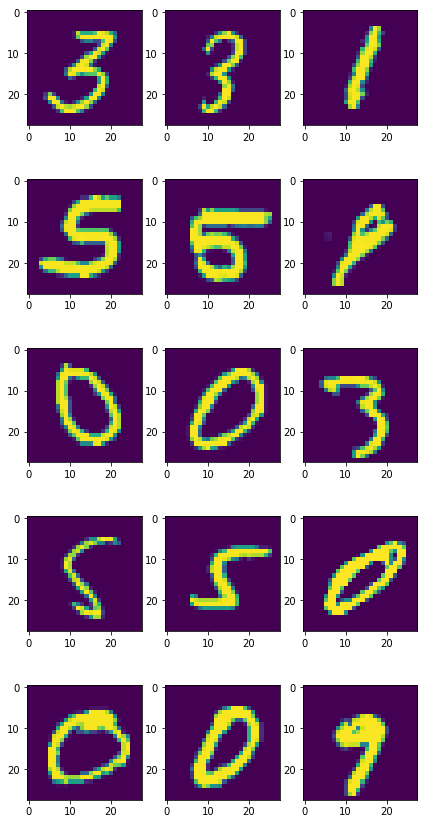

In [4]:
# Check some triplets
s = 10
n = 5
print(issame[3*s:(n+s)*3])
print(y_triplets[3*s:(n+s)*3])
fig = plt.figure(figsize=(7,3*n))
for i in range(s,s+n):
    plt.subplot(n,3,3*(i-s)+1)
    plt.imshow(triplets[3*i])
    plt.subplot(n,3,3*(i-s)+2)
    plt.imshow(triplets[3*i+1])
    plt.subplot(n,3,3*(i-s)+3)
    plt.imshow(triplets[3*i+2])

### Define the loss

In [6]:
import tensorflow.keras.backend as K
alpha = 0.3
def triplet_acc(y_true,y_pred):
    a = y_pred[0::3]
    p = y_pred[1::3]
    n = y_pred[2::3]
    
    ap = K.sum(K.square(a-p), axis = -1)
    an = K.sum(K.square(a-n), axis = -1)
    return K.less(ap,an)

In [25]:
import tensorflow.keras.backend as K

def robert(y_true,y_pred):
    """
    Robert tries to increase the angle between the centers
    of each classes (=increase the deviation of the centers)
    and to decrease the angle between elements of a certain class
    (=decrease the deviation of the elements of a class).
    """
    extract = tf.cast(y_true[:,0], dtype=tf.int32)
    classes = tf.one_hot(extract,depth=10)
    classes = tf.cast(classes, dtype=tf.float32)
    
    centers = K.transpose(K.dot(K.transpose(y_pred), classes / (K.sum(classes, axis=0, keepdims=True) + 1)))
    centers = tf.math.l2_normalize(centers,axis=-1)
    centers_classes = K.dot(classes, centers)
    
    # "dist" computes the angle
    dist = (K.sum(centers_classes * y_pred, axis=-1) * -1. + .5)*5
    dist = K.sum(K.sigmoid(dist))

    identity = K.arange(0,10)
    identity = tf.one_hot(identity,10)
    
    gram = K.dot(centers,K.transpose(centers)) * 0.5 + 0.5
    dev = K.sum(K.pow(gram-identity,10))
    return dev + dist

In [15]:
def bobby(y_true,y_pred):
    extract = tf.cast(y_true[:,0], dtype=tf.int32)
    classes = tf.one_hot(extract,depth=10)
    classes = tf.cast(classes, dtype=tf.float32)
    
    dot_y_pred = K.dot(y_pred,K.transpose(y_pred))
    is_same_mask = K.dot(classes,K.transpose(classes))

    return K.binary_crossentropy(is_same_mask,dot_y_pred*0.5+0.5)

In [70]:
s = 30.
m = 0.1
def cosine(y_true,y_pred):
    
    exp_s = K.exp(s * y_pred)
    exp_s_m = K.exp(s * (y_pred - m))
    
    masked_exp_s_m = exp_s_m * y_true
    
    inv_mask = 1. - y_true
    masked_exp_s = exp_s * inv_mask
    
    den = K.sum(masked_exp_s + masked_exp_s_m, axis=-1, keepdims=True)
    out = masked_exp_s_m / den
    out = K.sum(out,axis=-1)
    ret = - K.log(out)
    ret = K.sum(ret)
    return ret

### Define the network

In [5]:
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer

class Cosine(Layer):

    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(Cosine, self).__init__(**kwargs)

    def build(self, input_shape):
        shape = tf.TensorShape((input_shape[-1],self.output_dim))

        self.kernel = self.add_weight(name='kernel', 
                                      shape=shape,
                                      initializer='uniform',
                                      trainable=True)
        super(Cosine, self).build(input_shape)

    def call(self, x):
        x = tf.math.l2_normalize(x, axis=-1)
        w = tf.math.l2_normalize(self.kernel, axis=0)
        
        return K.dot(x, w)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

In [5]:
from triplet_loss import batch_all_triplet_loss
def triplet(y_true,y_pred):
    y_true = y_true[:,0]
    y_true = tf.reshape(y_true,[-1])
    loss,_ = batch_all_triplet_loss(y_true,y_pred,0.3)
    return loss

In [15]:
from triplet_loss import batch_hard_triplet_loss
def triplet_hard(y_true,y_pred):
    y_true = y_true[:,0]
    y_true = tf.reshape(y_true,[-1])
    loss = batch_hard_triplet_loss(y_true,y_pred,0.3)
    return loss

In [7]:
# Small net and cosine loss
emb_size = 2

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Lambda
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(emb_size))
model.add(Lambda(lambda x: tf.math.l2_normalize(x, axis=-1)))

model.compile(loss=triplet,
              optimizer='rmsprop',
              metrics=[triplet_acc]
             )
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               1179776   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
__________

In [8]:
y = np.expand_dims(y_triplets,-1)
y2 = np.hstack([y]*emb_size)
y2

array([[9., 9.],
       [9., 9.],
       [1., 1.],
       ...,
       [8., 8.],
       [8., 8.],
       [0., 0.]])

In [9]:
history = model.fit(
    triplets_exp,
    y2,
    batch_size = 30*3,
    epochs = 100,
    validation_split=0.1
)

Train on 54000 samples, validate on 6000 samples
Epoch 1/100
54000/54000 [==============================] - 10s 189us/step - loss: 0.3408 - triplet_acc: 0.5123 - val_loss: 0.3337 - val_triplet_acc: 0.9780
Epoch 2/100
54000/54000 [==============================] - 8s 154us/step - loss: 0.3885 - triplet_acc: 0.5047 - val_loss: 0.4141 - val_triplet_acc: 0.9845
Epoch 3/100
54000/54000 [==============================] - 8s 154us/step - loss: 0.4459 - triplet_acc: 0.4881 - val_loss: 0.3634 - val_triplet_acc: 0.9880
Epoch 4/100
54000/54000 [==============================] - 8s 154us/step - loss: 0.4643 - triplet_acc: 0.4988 - val_loss: 0.4062 - val_triplet_acc: 0.9820
Epoch 5/100
54000/54000 [==============================] - 8s 154us/step - loss: 0.4584 - triplet_acc: 0.4988 - val_loss: 0.4523 - val_triplet_acc: 0.9855
Epoch 6/100
54000/54000 [==============================] - 8s 154us/step - loss: 0.4645 - triplet_acc: 0.5060 - val_loss: 0.3760 - val_triplet_acc: 0.9880
Epoch 7/100
54000/54

KeyboardInterrupt: 

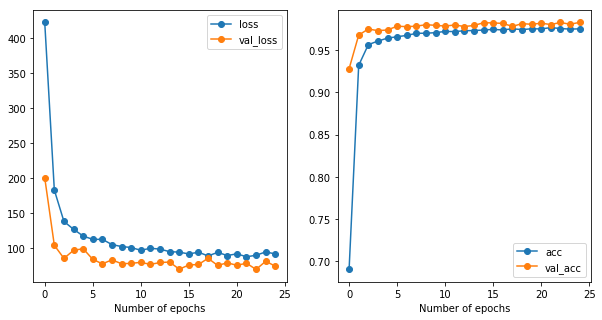

In [73]:
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['acc']
val_acc = history.history['val_acc']
history_ = np.array([loss,val_loss,acc,val_acc])
np.save(PATH_SAVE+'2018.01.31.small_net.cosine.s_30.m_0.1.npy',history_)
np.savetxt(PATH_SAVE+'2018.01.31.small_net.cosine.s_30.m_0.1.txt',history_)

epochs = np.arange(len(loss))
fig = plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(epochs,loss, '-o', label="loss")
plt.plot(epochs,val_loss, '-o', label="val_loss")
plt.xlabel("Number of epochs")
plt.legend()
plt.subplot(1,2,2)
plt.plot(epochs,acc, '-o', label="acc")
plt.plot(epochs,val_acc, '-o', label="val_acc")
plt.xlabel("Number of epochs")
plt.legend()

### Evaluate it

In [15]:
nbof_images = 6000

triplets_test = triplets_exp[:nbof_images]
mod = tf.keras.Model(model.input, model.layers[-2].output)
emb = mod.predict(triplets_test)
emb

array([[ -1.4668189,  12.624889 ],
       [ -2.4773555,  20.583328 ],
       [ 12.60317  , -13.208823 ],
       ...,
       [-13.415237 ,  12.262226 ],
       [ -9.318231 ,   8.507649 ],
       [-24.407066 ,   1.3547215]], dtype=float32)

In [16]:
a = emb[0::3]
p = emb[1::3]
n = emb[2::3]

# Computes distance between pairs
dist1 = np.sum(np.square(a-p),1)
dist2 = np.sum(np.square(a-n),1)
less = np.less(dist1,dist2)
acc = np.sum(less.astype(int))/len(less)
print(acc)

0.9005


16


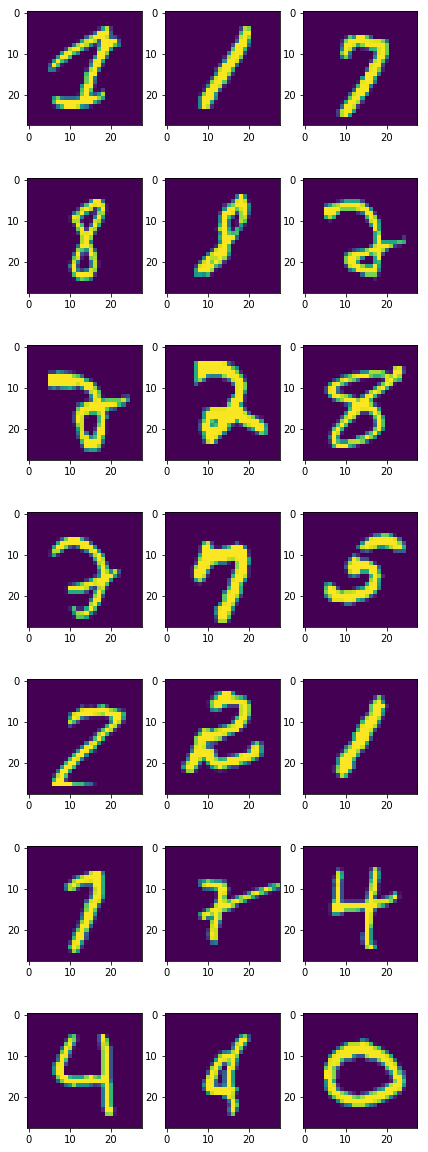

In [12]:
# Display the wrong examples
idx_wrong = np.logical_not(less)
idx_wrong = np.stack([idx_wrong]*3, axis = -1)
idx_wrong = np.reshape(idx_wrong, [-1])

wrong = triplets_test[idx_wrong]
wrong = np.squeeze(wrong)
print(len(wrong)//3)
s = 0
n = 7
e = n + s
plt.figure(figsize=(7,3*n))
for i in range(s,e):
    for j in range(3):
        plt.subplot(n,3,(i-s)*3+1+j)
        plt.imshow(wrong[i*3+j])

[[-11.78324248  10.77717964]
 [  9.80884088 -10.57441213]
 [ -7.59983268 -22.11241756]
 [-24.17507813   1.35444425]
 [ -7.59627628  14.48742452]
 [-16.1884872    6.22374995]
 [-12.92911319 -10.46980139]
 [ 10.45116574  23.93344779]
 [-15.93367908  -4.56414959]
 [ -2.06719157  17.24248929]]
[ 64.56026928  89.7907257  102.2643803   82.65048706  69.2507441
  66.12945831  73.64639792 109.84552475  68.80465163  77.1748704 ]


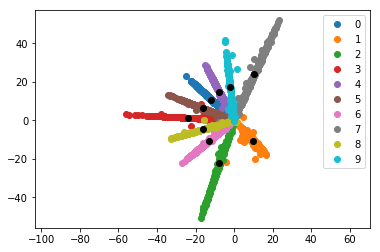

In [17]:
mean = np.zeros((10,2))
nb = np.zeros(10)
y_int = y_triplets[:nbof_images].astype(int)
predict = emb
# y_train = y_train.astype(int)
# y_int = np.empty(len(y_train),dtype=int)
# for i in range(len(y_train)):
#     idx = 0
#     while (y_train[i][idx]!=1):
#         idx += 1
#     y_int[i] = int(idx)

for i in range(len(predict)):
    mean[y_int[i]] += predict[i]
    nb[y_int[i]] += 1

for i in range(len(mean)):
    mean[i] /= nb[i]
print(mean)

std_vect = np.zeros((10,2)) + mean
std = np.zeros(10)
for i in range(len(predict)):
    std[y_int[i]] += np.sum(np.square(predict[i]-mean))

for i in range(len(mean)):
    std[i] /= nb[i]
print(np.sqrt(std))

plt.axis('equal')
n = 10
for i in range(n):
    y = predict[np.equal(i,y_int)]
    #y = y / np.linalg.norm(y, axis=-1,keepdims=True)
    plt.plot(y[:,0],y[:,1],'o',label=str(i))
#mean = mean/np.linalg.norm(mean, axis=-1,keepdims=True)
plt.plot(mean[:n,0],mean[:n,1],'ko')
plt.legend()

In [66]:
model.layers

In [34]:
mod = tf.keras.Model(model.inputs, model.layers[-2].output)
predict = mod.predict(x_train)

ValueError: Error when checking input: expected conv2d_14_input to have 4 dimensions, but got array with shape (60000, 28, 28)

In [35]:
mean = np.zeros((10,2))
nb = np.zeros(10)
y_int = y_train
# y_train = y_train.astype(int)
# y_int = np.empty(len(y_train),dtype=int)
# for i in range(len(y_train)):
#     idx = 0
#     while (y_train[i][idx]!=1):
#         idx += 1
#     y_int[i] = int(idx)

for i in range(len(predict)):
    mean[y_int[i]] += predict[i]
    nb[y_int[i]] += 1

for i in range(len(mean)):
    mean[i] /= nb[i]
print(mean)

std_vect = np.zeros((10,2)) + mean
std = np.zeros(10)
for i in range(len(predict)):
    std[y_int[i]] += np.sum(np.square(predict[i]-mean))

for i in range(len(mean)):
    std[i] /= nb[i]
print(np.sqrt(std))

plt.axis('equal')
n = 10
for i in range(n):
    y = predict[np.equal(i,y_int)]
    #y = y / np.linalg.norm(y, axis=-1,keepdims=True)
    plt.plot(y[:,0],y[:,1],'o',label=str(i))
#mean = mean/np.linalg.norm(mean, axis=-1,keepdims=True)
plt.plot(mean[:n,0],mean[:n,1],'ko')
plt.legend()

NameError: name 'predict' is not defined